In [38]:
import numpy as np 
import pandas as pd 
import torch 
import torch.nn as nn
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [39]:
#load data
(X_train,Y_train),(X_test,Y_test) = mnist.load_data()
#X 为图片 ，2维  y  为 label 
print(X_train.shape,Y_train.shape,Y_train[0])
print(X_test.shape,Y_test.shape,Y_test[0])


(60000, 28, 28) (60000,) 5
(10000, 28, 28) (10000,) 7


(-0.5, 27.5, 27.5, -0.5)

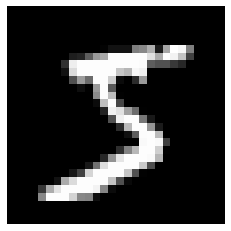

In [40]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0].reshape(28,28), cmap='gray');
# 关闭坐标轴
plt.axis('off')


In [41]:
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
import time
import torch.nn.functional as F
# training 時做 data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 隨機將圖片水平翻轉
    transforms.RandomRotation(15), # 隨機旋轉圖片
    transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization)
])
# testing 時不需做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [42]:
batch_size=256
train_set = ImgDataset(X_train,Y_train,test_transform)
val_set = ImgDataset(X_test,Y_test,test_transform)
train_loader = DataLoader(train_set,batch_size = batch_size,shuffle=True)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=False)

In [43]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [64,1, 28, 28]
        # self.cnn = nn.Sequential(
        #     nn.Conv2d(1, 16, 3, 1, 1),  # [64, 28, 28]
        #     nn.BatchNorm2d(16),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2, 0),      # [64, 14, 14]

        #     nn.Conv2d(16, 32, 3, 1, 1), # [128, 14, 14]
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2, 0),      # [128, 7, 7]
            
        #     nn.Conv2d(32, 64, 3, 1, 1), # [512, 7, 7]
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        # )
        self.fc = nn.Sequential(
            nn.Linear(784,512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        #out = self.cnn(x)
        x = x.view(-1, 784)
        #print(x.shape)
        out = self.fc(x)
        return out

class LinearR(nn.Module):
    def __init__(self):
        super(LinearR, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(784,512),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        #out = self.cnn(x)
        x = x.view(-1, 784)
        #print(x.shape)
        out = self.fc(x)
        return out

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [64,1, 28, 28]
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),  # [64, 28, 28]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 14, 14]

            nn.Conv2d(16, 32, 3, 1, 1), # [128, 14, 14]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 7, 7]
            
            nn.Conv2d(32, 64, 3, 1, 1), # [512, 7, 7]
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(784,512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        out = self.cnn(x)
        x = x.view(-1, 784)
        #print(x.shape)
        out = self.fc(x)
        return out

In [44]:
#setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
# print(device)
model = Classifier().to(device)
cirection = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)


In [45]:
epochs = 20
for epoch in range(epochs):
    epoch_start_time = time.time()
    train_acc =0.0
    val_acc =0.0
    train_loss = 0.0
    val_loss =0.0
    model.train()
    for i,data in enumerate(train_loader):
        optimizer.zero_grad()
        x,y = data[0].to(device),data[1].to(device)
        #print(x.shape)
        y_pred = model(x)
        loss = cirection(y_pred,y.long())
        loss.backward()
        optimizer.step()
        train_acc +=np.sum(np.argmax(y_pred.cpu().data.numpy(),axis=1)== y.cpu().numpy())
        train_loss +=loss.item()
    model.eval()
    with torch.no_grad():
        for i,data in enumerate(val_loader):
            valx ,valy = data[0].to(device),data[1].to(device)
            val_pred = model(valx)
            batch_loss = cirection(val_pred,valy.long())
            val_acc +=np.sum(np.argmax(val_pred.cpu().data.numpy(),axis=1)== valy.cpu().numpy())
            val_loss +=batch_loss.item()

        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, epochs, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))
    model.train()

[001/020] 5.65 sec(s) Train Acc: 0.897733 Loss: 0.001533 | Val Acc: 0.942300 loss: 0.000783
[002/020] 5.90 sec(s) Train Acc: 0.952100 Loss: 0.000648 | Val Acc: 0.960100 loss: 0.000527
[003/020] 6.34 sec(s) Train Acc: 0.967533 Loss: 0.000440 | Val Acc: 0.966900 loss: 0.000419
[004/020] 5.50 sec(s) Train Acc: 0.975350 Loss: 0.000332 | Val Acc: 0.971900 loss: 0.000364
[005/020] 5.29 sec(s) Train Acc: 0.981050 Loss: 0.000255 | Val Acc: 0.976500 loss: 0.000312
[006/020] 5.28 sec(s) Train Acc: 0.985133 Loss: 0.000204 | Val Acc: 0.978000 loss: 0.000285
[007/020] 5.74 sec(s) Train Acc: 0.988800 Loss: 0.000161 | Val Acc: 0.978000 loss: 0.000286
[008/020] 5.38 sec(s) Train Acc: 0.990683 Loss: 0.000129 | Val Acc: 0.978500 loss: 0.000259
[009/020] 5.28 sec(s) Train Acc: 0.992617 Loss: 0.000109 | Val Acc: 0.979100 loss: 0.000257
[010/020] 5.43 sec(s) Train Acc: 0.994900 Loss: 0.000084 | Val Acc: 0.981300 loss: 0.000233
[011/020] 5.28 sec(s) Train Acc: 0.996317 Loss: 0.000067 | Val Acc: 0.979800 los